In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, plot_confusion_matrix
import numpy as np

In [4]:
# Import Data
df = pd.read_sas('../Data/nsch_2020_topical_SAS/nsch_2020_topical.sas7bdat')

/Users/matthewturner/opt/anaconda3/envs/Capstone/lib/python3.9/site-packages/pandas/io/sas/sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")


In [5]:
# Checking for NaN values
df.isna().sum()

FIPSST       0
STRATUM      0
HHID         0
FORMTYPE     0
TOTKIDS_R    0
            ..
FPL_I3       0
FPL_I4       0
FPL_I5       0
FPL_I6       0
FWC          0
Length: 443, dtype: int64

In [6]:
# There are only a 188 NANs in the target, I will opt to drop them
df.dropna(subset=['K2Q31A'], inplace=True)

In [7]:
# For the rest of the columns, I will fill in a value that CATBOOST will easily be able to identify as a NAN
df.fillna(-999, inplace=True)

In [8]:
# Target: Diagnosed ADHD
y = df['K2Q31A']

# Dropping ANYTHING related to ADHD and treatment
X = df.drop(columns=['K2Q31A', 'ADDTREAT', 'K2Q31B', 'K2Q31C', 'K2Q31D'])

In [9]:
# Get the indices of object columns
categorical_features_indices = np.where(df.dtypes != float)[0]

In [10]:
# TTS
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

In [11]:
# Setting up the model
model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)

In [12]:
# Fit the model on the data.
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    # Plot the learning of the model
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [13]:
# Cross Validate
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(
    Pool(X, list(y), cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [14]:
# print the best validation accuracy score
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.95±0.00 on step 770


In [15]:
# Printing the ean accuracy score
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.9488835348645926


/Users/matthewturner/opt/anaconda3/envs/Capstone/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


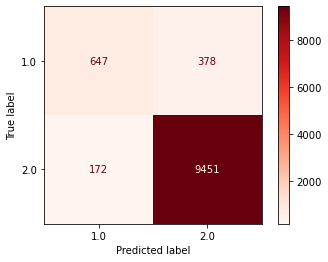

In [16]:
# Plot confusion Matrix for test set.
plot_confusion_matrix(model, X_validation, y_validation, cmap='Reds')

In [19]:
accuracy_score(y_validation, model.predict(X_validation))

0.9483471074380165

In [20]:
precision_score(y_validation, model.predict(X_validation))

0.78998778998779

In [21]:
recall_score(y_validation, model.predict(X_validation))

0.631219512195122

In [22]:
f1_score(y_validation, model.predict(X_validation))

0.7017353579175706

In [23]:
roc_auc_score(y_validation, model.predict(X_validation))

0.8066728341397515

In [26]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,K4Q23,11.345705
1,K2Q34A,3.833775
2,UNDERSTAND,3.407974
3,MEMORYCOND,2.895235
4,SC_SEX,2.726268
...,...,...
433,HIGRADE,0.000000
434,BIRTHWT_VL,0.000000
435,BIRTHWT,0.000000
436,A1_GRADE_IF,0.000000


- **K4Q23** = DURING THE PAST 12 MONTHS, has this child taken any medication because of difficulties with
their emotions, concentration, or behavior?
    - This may need to be removed
<br>

- **K2Q34A** = Has a doctor, other health care provider, or educator EVER told you that this child
has Behavioral or Conduct Problems?
<br>

- **UNDERSTAND** = Is this child able to do the following:
Understand the meaning of the word "no"?
